In [1]:
from collections import defaultdict
from itertools import product
import os
import warnings

import matplotlib
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import matplotlib.transforms
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
from statannotations.Annotator import Annotator

# Params
DATA_FOLDER = os.path.join(os.path.abspath(''), '../../data')
RESULTS_FOLDER = os.path.join(os.path.abspath(''), '../results')
PLOTS_FOLDER = os.path.join(os.path.abspath(''), '../plots')

# Style
sns.set_theme(context='talk', style='white', palette='Accent')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Helvetica'  # NOTE: Make sure to download Helvetica

# Color palette
inhibitory_ct = np.array(['Lamp5', 'Pvalb', 'Sncg', 'Sst', 'Lamp5.Lhx6', 'Vip', 'Pax6', 'Chandelier'])  # 'Sst.Chodl'
excitatory_ct = np.array(['L2.3.IT', 'L4.IT', 'L5.IT', 'L5.ET', 'L5.6.NP', 'L6b', 'L6.IT', 'L6.CT', 'L6.IT.Car3'])
major_ct = np.array(['astro', 'endo', 'excitatory', 'inhibitory', 'micro', 'oligo', 'opc', 'vlmc'])
minor_ct = np.array(list(inhibitory_ct) + list(excitatory_ct))
merged_ct = np.array(list(major_ct) + list(minor_ct))
conversion_ct = {**{ct: 'inhibitory' for ct in inhibitory_ct}, **{ct: 'excitatory' for ct in excitatory_ct}, **{ct: ct for ct in major_ct}}

# Colors
# major_palette = sns.color_palette('Dark2', as_cmap=True)
# minor_palette = sns.color_palette('magma', as_cmap=True)
major_palette = minor_palette = lambda _: (.5, .5, .5, 1.)
major_colors = {ct: major_palette((i+1) / (len(major_ct) + 1)) for i, ct in enumerate(major_ct)}
minor_colors = {ct: minor_palette((i+1) / (len(minor_ct) + 1)) for i, ct in enumerate(minor_ct)}
for ct in minor_colors: minor_colors[ct] = major_colors[conversion_ct[ct]]  # Override minor colors with parent type
merged_colors = major_colors | minor_colors

### Color Legends

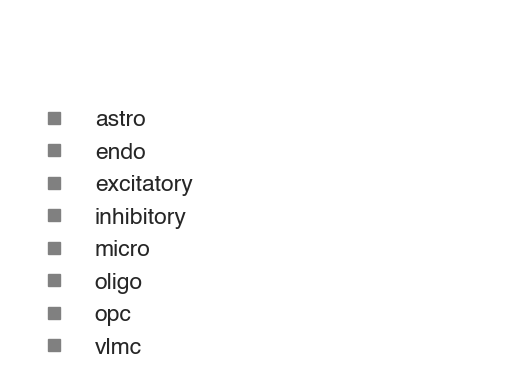

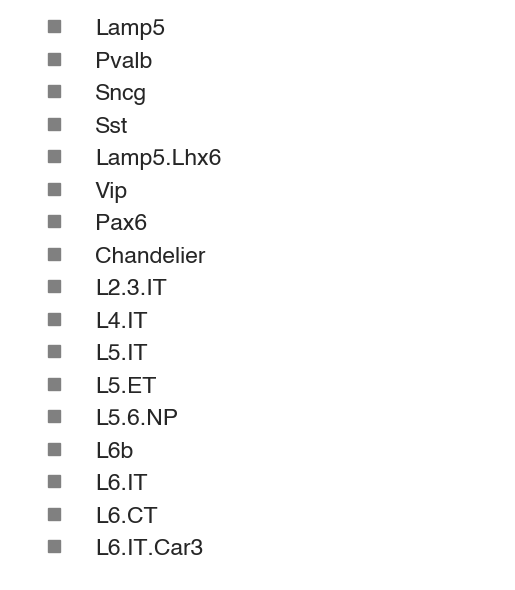

In [2]:
# Major and legends
for name, colors in zip(('major', 'minor'), (major_colors, minor_colors)):
    fig, ax = plt.subplots(1, 1)
    ax.spines.top.set_visible(False)  # Avoid line through legend if too long
    handles = [ax.plot([], [], color=c, marker='s', ls='none')[0] for c in colors.values()]
    labels = list(colors.keys())
    legend = plt.legend(handles, labels, loc=3, frameon=False)
    ax.axis('off')
    fname = f'legend_{name}.pdf'
    fig.savefig(os.path.join(PLOTS_FOLDER, fname), bbox_inches='tight')

### Preliminary Functions

In [3]:
# Preliminary parameters and functions
"""
Cohort : Disease : Delimiter
CMC: SCZ : tsv
UCLA_ASD: ASD : csv
Urban_DLPFC: BPD, SCZ : tsv
Subclass: ASD, BPD, SCZ : csv
"""
data_sources = (
    ('CMC', 'SCZ', '\t'),
    ('UCLA_ASD', 'ASD', ','),
    ('Urban_DLPFC', 'BPD', '\t'),
    # ('Urban_DLPFC', 'SCZ', '\t'),  # Removed for low sample size
    ('Subclass', 'ASD', ','),
    ('Subclass', 'BPD', ','),
    ('Subclass', 'SCZ', ','),
    # ('Coregulation', 'ASD', ','),
    # ('Coregulation', 'BPD', ','),
    # ('Coregulation', 'SCZ', ','),
)
modules = [None, 1, 2]
use_ctl = False  # Not really needed here

# Get AD, BPD, and SCZ labels
gene_dir = os.path.join(DATA_FOLDER, 'new_labels')
gene_fnames = [fname for fname in os.listdir(gene_dir) if fname.endswith('.txt')]
gene_lists = {'.'.join(fname.split('.')[:-1]): np.loadtxt(os.path.join(gene_dir, fname), dtype=str) for fname in gene_fnames}
gene_lists['BPD'] = gene_lists.pop('BD')

# Get ASD labels
sfari = pd.read_csv(os.path.join(DATA_FOLDER, 'sfari/SFARI-Gene_genes_01-16-2024release_03-21-2024export.csv'))
gene_score_threshold = -1
sfari = sfari.loc[sfari['gene-score'] > gene_score_threshold]  # Threshold by score
gene_lists['ASD'] = sfari['gene-symbol'].to_numpy()

# Get module genes
def get_module_genes(group, disease, ct, use_modules=None):
    gene_annotations = pd.read_csv(os.path.join(DATA_FOLDER, 'modules', get_modules_fname(use_modules=use_modules), f'{ct}_{group}_{disease}.txt'), index_col=False, delimiter=',')
    positive_genes = gene_annotations.loc[gene_annotations['label']=='positive', 'gene'].to_list()
    negative_genes = gene_annotations.loc[gene_annotations['label']=='negative', 'gene'].to_list()
    return positive_genes, negative_genes

# Get files for contrast
def get_grn_fnames(group, disease, use_ctl=True):
    # Calculate directories
    base_dir = os.path.join(DATA_FOLDER, 'merged_GRNs_v2', group)
    disease_folder = os.path.join(base_dir, disease)
    if use_ctl:
        control_folder = os.path.join(base_dir, 'ctrl')
        grn_fnames = np.sort(list(set(os.listdir(disease_folder)).intersection(set(os.listdir(control_folder)))))
    else: grn_fnames = np.sort(os.listdir(disease_folder)) 

    # Return
    ret = ()
    ret += (base_dir, disease_folder)
    if use_ctl: ret += (control_folder,)
    ret += (grn_fnames,)
    # base_dir, disease_folder, control_folder, grn_fnames
    return ret

# Get fname suffix
def get_modules_fname(use_modules, **kwargs): return f'model{use_modules}' if use_modules is not None else ''
def get_fname_suffix(**kwargs):
    suffixes = [get_modules_fname(**kwargs)]
    suffixes = [s for s in suffixes if len(s) > 0]
    if len(suffixes) == 0: return ''
    return f'_{"_".join(suffixes)}'

# Get cell-type based on fname
def get_cell_type(fname):
    split_fname = fname.split('_')
    if split_fname[-1] == 'coreg.matrix.txt':
        return split_fname[1]
    return '_'.join(split_fname[:-1])

### Data Compilation

##### Performance

In [4]:
# Performance dataframe
performance = pd.DataFrame()
for source, use_modules in product(data_sources, modules):
    group, disease, delimiter = source

    # Skip non-models
    if not use_modules: continue

    # Load performance
    fname = os.path.join(RESULTS_FOLDER, f'{group}_{disease}_performance{get_fname_suffix(use_modules=use_modules)}.csv')
    try: df = pd.read_csv(fname, index_col=0)
    except: continue
    df['Group'] = group
    df['Disease'] = disease
    df['Model'] = f'Model {use_modules}'

    # Get baselines
    def get_baseline(ct):
        df_temp = pd.read_csv(os.path.join(RESULTS_FOLDER, f'{group}_{disease}_{ct}_prioritized_genes{get_fname_suffix(use_modules=use_modules)}.csv'), index_col=0)
        num_neg = (df_temp['label'] == 0).sum()
        num_pos = (df_temp['label'] == 1).sum()
        baseline = num_pos / (num_pos + num_neg)

        return baseline
    df['Baseline AUPRC'] = df['Cell Type'].map(get_baseline)

    # Concatenate
    performance = pd.concat((performance, df), axis=0)

# Apply formatting
# performance['Dataset'] = performance.apply(lambda r: f'{r["Group"]} ({r["Disease"]})', axis=1)  # Include group name
performance['Dataset'] = performance.apply(lambda r: f'{r["Group"]} - {r["Disease"]} - {r["Cell Type"]}', axis=1)  # Exclude group name

# Aggregate values
performance['AUPRC Fold'] = performance['Validation AUPRC'] / performance['Baseline AUPRC']

# Sort df
performance['Subclass'] = performance['Group'] == 'Subclass'
performance = performance.sort_values(['Disease', 'Subclass', 'Group']).drop(columns='Subclass')

# Create aggregate df
performance_mean = performance.groupby(['Model', 'Group', 'Disease', 'Cell Type']).mean(numeric_only=True).drop(columns='Fold').reset_index()

##### Results

In [5]:
# Load all results (Taken from model-ensemble)
results = pd.DataFrame()
for source in data_sources:
    group, disease, _ = source
    grn_fnames = get_grn_fnames(group, disease, use_ctl=use_ctl)[-1]

    for fname, use_modules in product(grn_fnames, modules):
        # Load prioritized genes
        cell_type = get_cell_type(fname)
        result_fname = f'{group}_{disease}_{cell_type}_prioritized_genes{get_fname_suffix(use_modules=use_modules)}.csv'
        try: result = pd.read_csv(os.path.join(RESULTS_FOLDER, result_fname), index_col=0).reset_index()
        except: print(f'Failed to read "{result_fname}"'); continue

        # Tag df
        renames = {'label': 'Label', 'mean': 'Mean', 'std': 'STD', 'gene': 'Gene'}
        result = result.rename(columns=renames)[renames.values()]
        result['Group'] = group
        result['Disease'] = disease
        result['Cell Type'] = cell_type
        result['Model'] = use_modules

        # Append
        results = pd.concat((results, result), axis=0)
results = results.reset_index(drop=True)
results['Model'] = results['Model'].fillna('None')  # Necessary for proper groupby behavior
group_cols = ['Model', 'Group', 'Disease', 'Cell Type']

In [6]:
# Load sfari dataset
sfari = pd.read_csv(os.path.join(DATA_FOLDER, 'sfari/SFARI-Gene_genes_01-16-2024release_03-21-2024export.csv'))

# Gene scoring information: https://gene.sfari.org/about-gene-scoring/
candidates = sfari.loc[sfari['gene-score'] == 2]  # Take strong candidate genes
candidate_genes = candidates['gene-symbol'].to_list()

# Annotate genes
results_candidates = results.copy()
results_candidates = results_candidates.set_index(group_cols)
results_candidates['Candidate'] = results_candidates['Gene'].isin(candidate_genes)

# Filter
results_candidates = results_candidates.loc[results_candidates.index.get_level_values('Disease') == 'ASD']

# Annotate percentile
for idx in results_candidates.index.unique():
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')

        # Annotate sub df with percentiles
        df = results_candidates.loc[idx]
        results_candidates.loc[idx, 'Percentile'] = df.apply(lambda r: 100 * sum(r['Mean'] > df['Mean']) / df.shape[0], axis=1)

# Annotate decile
results_candidates['Decile'] = (results_candidates['Percentile'] / 10).astype(int) + 1

# Compute candidates by decile
decile_counts = results_candidates.loc[results_candidates['Candidate']].reset_index().groupby(group_cols + ['Decile']).count()[['Mean']].rename(columns={'Mean': 'Candidates'}).reset_index('Decile')

# Fill any zero counts
for idx in decile_counts.index.unique():
    for d in range(1, 11):
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            if d not in decile_counts.loc[idx, 'Decile'].to_list():
                blank_row = pd.DataFrame({k: v for k, v in zip(decile_counts.index.names, idx)} | {'Decile': d, 'Candidates': 0}, index=[0]).set_index(group_cols)
                decile_counts = pd.concat((decile_counts, blank_row), axis=0)

In [7]:
# BBB counts
# Load drugs and gene lists
drugs = pd.read_csv(os.path.join(DATA_FOLDER, 'pharmacologically_active.csv')).rename(columns={'Drug IDs': 'Drug ID'})
drugs = drugs[['Gene Name', 'Drug ID', 'Species']]
drugs = drugs.loc[drugs['Species'] == 'Humans']
drugs['Drug ID'] = drugs['Drug ID'].apply(lambda s: s.split('; '))
drugs = drugs.explode('Drug ID')

# Add BBB predictions
bbb = pd.read_csv(os.path.join(DATA_FOLDER, 'BBB_plus_dbIDS.csv'), index_col=0)
drugs['BBB'] = drugs['Drug ID'].map(lambda x: x in list(bbb['ID']))

# Get bbb targets and compare to counts of non-targets
bbb_drug_targets, bbb_drug_targets_counts = np.unique(drugs.loc[drugs['BBB'], 'Gene Name'].to_list(), return_counts=True)
non_bbb_drug_targets, non_bbb_drug_targets_counts = np.unique(drugs.loc[~drugs['BBB'], 'Gene Name'].to_list(), return_counts=True)
bbb_drug_targets_df = pd.DataFrame({'Positive': bbb_drug_targets_counts / drugs['BBB'].sum()}, index=bbb_drug_targets)
non_bbb_drug_targets_df = pd.DataFrame({'Negative': non_bbb_drug_targets_counts / (~drugs['BBB']).sum()}, index=non_bbb_drug_targets)
comparison_df = pd.concat((bbb_drug_targets_df, non_bbb_drug_targets_df), axis=1).fillna(0)
comparison_df['Difference'] = comparison_df['Positive'] - comparison_df['Negative']
# Outputs
bbb_targets = comparison_df.loc[comparison_df['Positive'] > 0].index.to_numpy()  # Any positive targets
# bbb_targets = bbb_drug_targets[bbb_drug_targets_counts > np.percentile(bbb_drug_targets_counts, 90)]  # Top decile
# bbb_targets = comparison_df.loc[(comparison_df['Positive'] > 0) * (comparison_df['Negative'] == 0)].index.to_numpy()  # Only present in BBB positive
# bbb_targets = comparison_df.loc[comparison_df['Positive'] > comparison_df['Negative']].index.to_numpy()  # Larger proportion in BBB positive
# bbb_targets = comparison_df.loc[comparison_df['Difference'] >= comparison_df.loc[comparison_df['Difference'] >= 0, 'Difference'].quantile(.9)].index.to_numpy()  # 90th percentile positive difference between positive and negative
print(f'Using {bbb_targets.shape[0]} BBB positive genes')
    
# Format and decide targets
drug_results = results.copy()
drug_results['BBB Count'] = drug_results['Gene'].isin(bbb_targets)
drug_results = drug_results.set_index(group_cols)

# Filter to top decile of results
thresholds = drug_results.groupby(group_cols).quantile(.9, numeric_only=True)[['Mean']]
drug_results['_mask'] = None
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for idx in thresholds.index:
        drug_results.loc[idx, '_mask'] = drug_results.loc[idx, 'Mean'] >= thresholds.loc[idx, 'Mean']
assert drug_results['_mask'].isna().sum() == 0, 'Not all values checked'
# Compute counts of BBB targets and pivot separate by model
bbb_counts = drug_results.loc[drug_results['_mask']].drop(columns='_mask').groupby(group_cols)[['BBB Count']].sum()

# Find average percentile of BBB targets
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    print(f'({drug_results.index.unique().shape[0]})', end=' ')
    for i, idx in enumerate(drug_results.index.unique()):
        # CLI
        if i % 20 == 0:
            print(i, end='.')
        # Get data
        subset = drug_results.loc[idx]
        # Compute percentile
        drug_results.loc[idx, 'Percentile'] = subset.apply(lambda r: 100 * (r['Mean'] > subset['Mean']).sum() / subset.shape[0], axis=1)
        # Compute average percentile of positive genes
        if drug_results.loc[idx, 'BBB Count'].sum() > 0:
            bbb_counts.loc[idx, 'BBB Percentile'] = drug_results.loc[drug_results['BBB Count']].loc[idx, 'Percentile'].mean()  # Other order causes extreme lag
        else: bbb_counts.loc[idx, 'BBB Percentile'] = 0  # Skip if no targets are present
    print('Done')
bbb_counts = bbb_counts.reset_index()

Using 367 BBB positive genes
(225) 0.20.40.60.80.100.120.140.160.180.200.220.Done


### Performance

## major ##  (Model 2 / Tie / Model 1) : (21/1/2) (Total 24)
## minor ##  (Model 2 / Tie / Model 1) : (26/17/8) (Total 51)


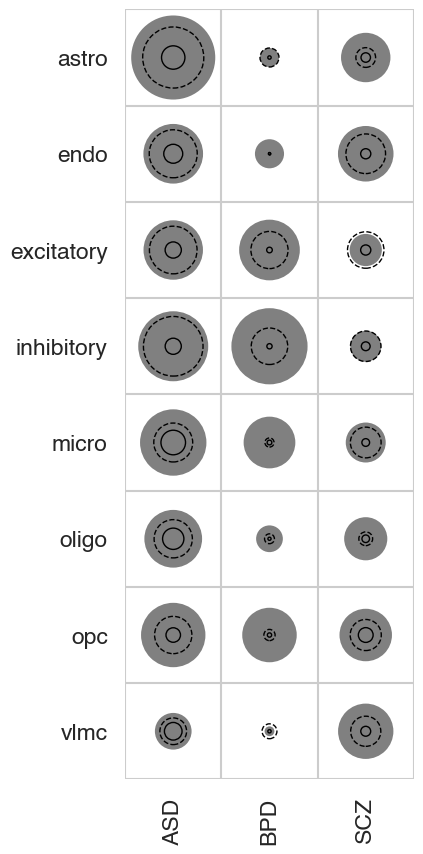

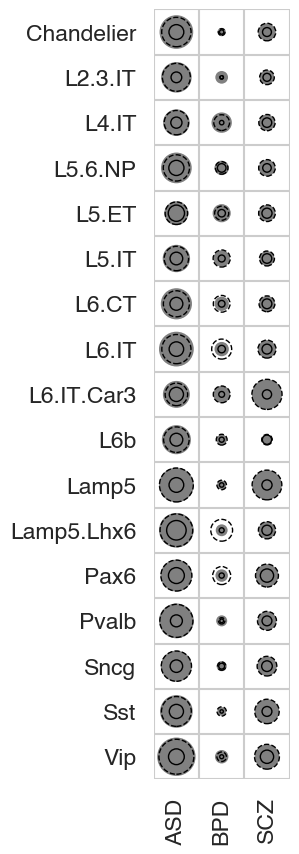

In [8]:
for name, ct_to_use in zip(('major', 'minor'), (major_ct, minor_ct)):
    # Performance heatmap
    heatmap_baseline = performance_mean.loc[(performance_mean['Model'] == 'Model 1') * (performance_mean['Cell Type'].isin(ct_to_use))].pivot(index='Cell Type', columns='Disease', values='Baseline AUPRC').iloc[::-1]
    heatmap_1 = performance_mean.loc[(performance_mean['Model'] == 'Model 1') * (performance_mean['Cell Type'].isin(ct_to_use))].pivot(index='Cell Type', columns='Disease', values='Validation AUPRC').iloc[::-1]
    heatmap_2 = performance_mean.loc[(performance_mean['Model'] == 'Model 2') * (performance_mean['Cell Type'].isin(ct_to_use))].pivot(index='Cell Type', columns='Disease', values='Validation AUPRC').iloc[::-1]

    # Compute relative performance
    num_greater = (heatmap_2.to_numpy() > heatmap_1.to_numpy()).sum()
    num_equal = (heatmap_2.to_numpy() == heatmap_1.to_numpy()).sum()
    num_less = (heatmap_2.to_numpy() < heatmap_1.to_numpy()).sum()
    num_total = heatmap_2.to_numpy().flatten().shape[0]
    print(f'## {name} ##  (Model 2 / Tie / Model 1) : ({num_greater}/{num_equal}/{num_less}) (Total {num_total})')

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Define vars
    xlabels = heatmap_2.columns.to_list()
    ylabels = heatmap_2.index.to_list()
    m, n = heatmap_2.shape[1], heatmap_2.shape[0]
    X, Y = np.meshgrid(np.arange(m), np.arange(n))
    S = heatmap_baseline.to_numpy()
    T = heatmap_1.to_numpy()
    U = heatmap_2.to_numpy()

    # Baseline is solid
    patches = [plt.Circle((j, i), radius=r/2) for j, i, r in zip(X.flat, Y.flat, S.flat)]
    col = PatchCollection(patches, fc=(0, 0, 0, 0), ec='black', linewidth=1, linestyle='-')
    ax.add_collection(col)

    # Model 1 is dashed
    patches = [plt.Circle((j, i), radius=r/2) for j, i, r in zip(X.flat, Y.flat, T.flat)]
    col = PatchCollection(patches, fc=(0, 0, 0, 0), ec='black', linewidth=1, linestyle='--')
    ax.add_collection(col)

    # Model 2 is colored
    patches = [plt.Circle((j, i), radius=r/2) for j, i, r in zip(X.flat, Y.flat, U.flat)]
    col = PatchCollection(patches, array=Y.flat, linewidth=0, zorder=-1)
    ax.add_collection(col)

    # Modify colors to match cell types
    fig.canvas.draw()
    facecolors = col.get_facecolors()
    for i, x, y in zip(range(facecolors.shape[0]), X.flat, Y.flat):
        ct = ylabels[y]
        facecolors[i] = merged_colors[ct]
    col.set_array(None)
    col.set_facecolors(facecolors)
    fig.canvas.draw()

    # Set ticks
    ax.set(
        xticks=np.arange(m),
        yticks=np.arange(n),
        xticklabels=xlabels,
        yticklabels=ylabels,
    )
    ax.set_xticks(np.arange(m+1)-.5, minor=True)
    ax.set_yticks(np.arange(n+1)-.5, minor=True)
    ax.tick_params(axis='x', labelrotation=90)
    ax.grid(which='minor')
    ax.set_aspect('equal', adjustable='box')

    # Formatting
    ax.spines.left.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.bottom.set_visible(False)

    # Save
    fname = f'performance_{name}.pdf'
    fig.savefig(os.path.join(PLOTS_FOLDER, fname), bbox_inches='tight')

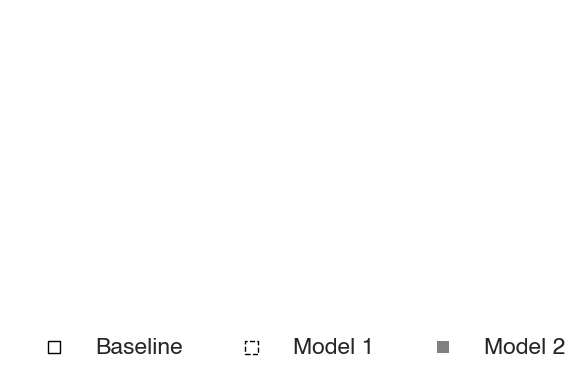

In [9]:
# Performance legend
fig, ax = plt.subplots(1, 1)
ax.spines.top.set_visible(False)  # Avoid line through legend if too long
handles = [
    plt.scatter([], [], marker='s', facecolors=(0, 0, 0, 0), edgecolors='black', ls='-', lw=1),
    plt.scatter([], [], marker='s', facecolors=(0, 0, 0, 0), edgecolors='black', ls='--', lw=1),
    plt.scatter([], [], marker='s', facecolors='gray', edgecolors=(0, 0, 0, 0), lw=0),
]
labels = ['Baseline', 'Model 1', 'Model 2']
legend = plt.legend(handles, labels, ncol=3, loc=3, frameon=False)
ax.axis('off')
fname = f'legend_performance.pdf'
fig.savefig(os.path.join(PLOTS_FOLDER, fname), bbox_inches='tight')

### BBB Comparison

## major ##  (Model 2 / Tie / Model 1) : (11/1/12) (Total 24)
## minor ##  (Model 2 / Tie / Model 1) : (11/26/14) (Total 51)


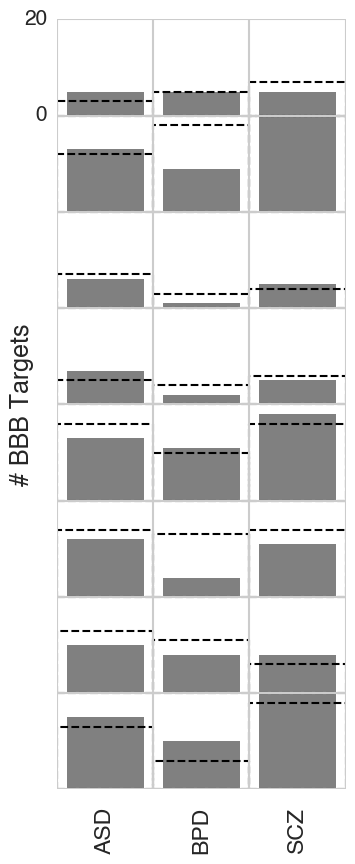

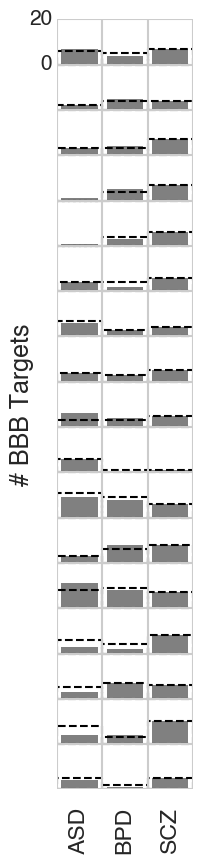

In [10]:
for name, ct_to_use in zip(('major', 'minor'), (major_ct, minor_ct)):
    # BBB Heatmap
    analysis_type = 0
    values = ('BBB Count', 'BBB Percentile')[analysis_type]
    ylabel = ('# BBB Targets', 'Mean BBB Percentile')[analysis_type]
    heatmap_1 = bbb_counts.loc[(bbb_counts['Model'] == 1) * (bbb_counts['Cell Type'].isin(ct_to_use))].pivot(index='Cell Type', columns='Disease', values=values).iloc[::-1]
    heatmap_2 = bbb_counts.loc[(bbb_counts['Model'] == 2) * (bbb_counts['Cell Type'].isin(ct_to_use))].pivot(index='Cell Type', columns='Disease', values=values).iloc[::-1]

    # Compute relative performance
    num_greater = (heatmap_2.to_numpy() > heatmap_1.to_numpy()).sum()
    num_equal = (heatmap_2.to_numpy() == heatmap_1.to_numpy()).sum()
    num_less = (heatmap_2.to_numpy() < heatmap_1.to_numpy()).sum()
    num_total = heatmap_2.to_numpy().flatten().shape[0]
    print(f'## {name} ##  (Model 2 / Tie / Model 1) : ({num_greater}/{num_equal}/{num_less}) (Total {num_total})')

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Define vars
    xlabels = heatmap_2.columns.to_list()
    ylabels = heatmap_2.index.to_list()
    m, n = heatmap_2.shape[1], heatmap_2.shape[0]
    X, Y = np.meshgrid(np.arange(m), np.arange(n))
    S = heatmap_1.to_numpy()
    T = heatmap_2.to_numpy()

    # Scale values
    maxval = 20
    S = S / maxval
    T = T / maxval
    S[S>1]=1; T[T>1]=1

    # Model 1 is dashed
    patches = [plt.Rectangle((j-.5, i-.5), 1, v) for j, i, v in zip(X.flat, Y.flat, S.flat)]
    col = PatchCollection(patches, fc=(0, 0, 0, 0), ec='black', linewidth=1.5, linestyle='--', zorder=-1)
    ax.add_collection(col)

    # Model 2 is colored
    patches = [plt.Rectangle((j-.4, i-.5), .8, v) for j, i, v in zip(X.flat, Y.flat, T.flat)]
    col = PatchCollection(patches, array=Y.flat, linewidth=0, zorder=-2)
    ax.add_collection(col)

    # Modify colors to match cell types
    fig.canvas.draw()
    facecolors = col.get_facecolors()
    for i, x, y in zip(range(facecolors.shape[0]), X.flat, Y.flat):
        ct = ylabels[y]
        facecolors[i] = merged_colors[ct]
    col.set_array(None)
    col.set_facecolors(facecolors)
    fig.canvas.draw()

    # Set ticks
    ax.set(
        xticks=np.arange(m),
        yticks=np.arange(n),
        xticklabels=xlabels,
        yticklabels=ylabels,
    )
    ax.set_xticks(np.arange(m+1)-.5, minor=True)
    ax.set_yticks(np.arange(n+1)-.5, minor=True)
    ax.tick_params(axis='x', labelrotation=90)
    ax.grid(which='minor')
    ax.set_aspect('equal', adjustable='box')

    # Formatting
    ax.spines.left.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.bottom.set_visible(False)

    # Labels
    ax.set_ylabel(ylabel)
    ax.text(-.6, heatmap_1.shape[0]-.5, f'{maxval}', fontsize='small', ha='right', va='center', transform=ax.transData)
    ax.text(-.6, heatmap_1.shape[0]-1.5, '0', fontsize='small', ha='right', va='center', transform=ax.transData)
    ax.set_yticklabels([])

    # Save
    fname = f'bbb_{name}.pdf'
    fig.savefig(os.path.join(PLOTS_FOLDER, fname), bbox_inches='tight')

### Deciles and Distribution

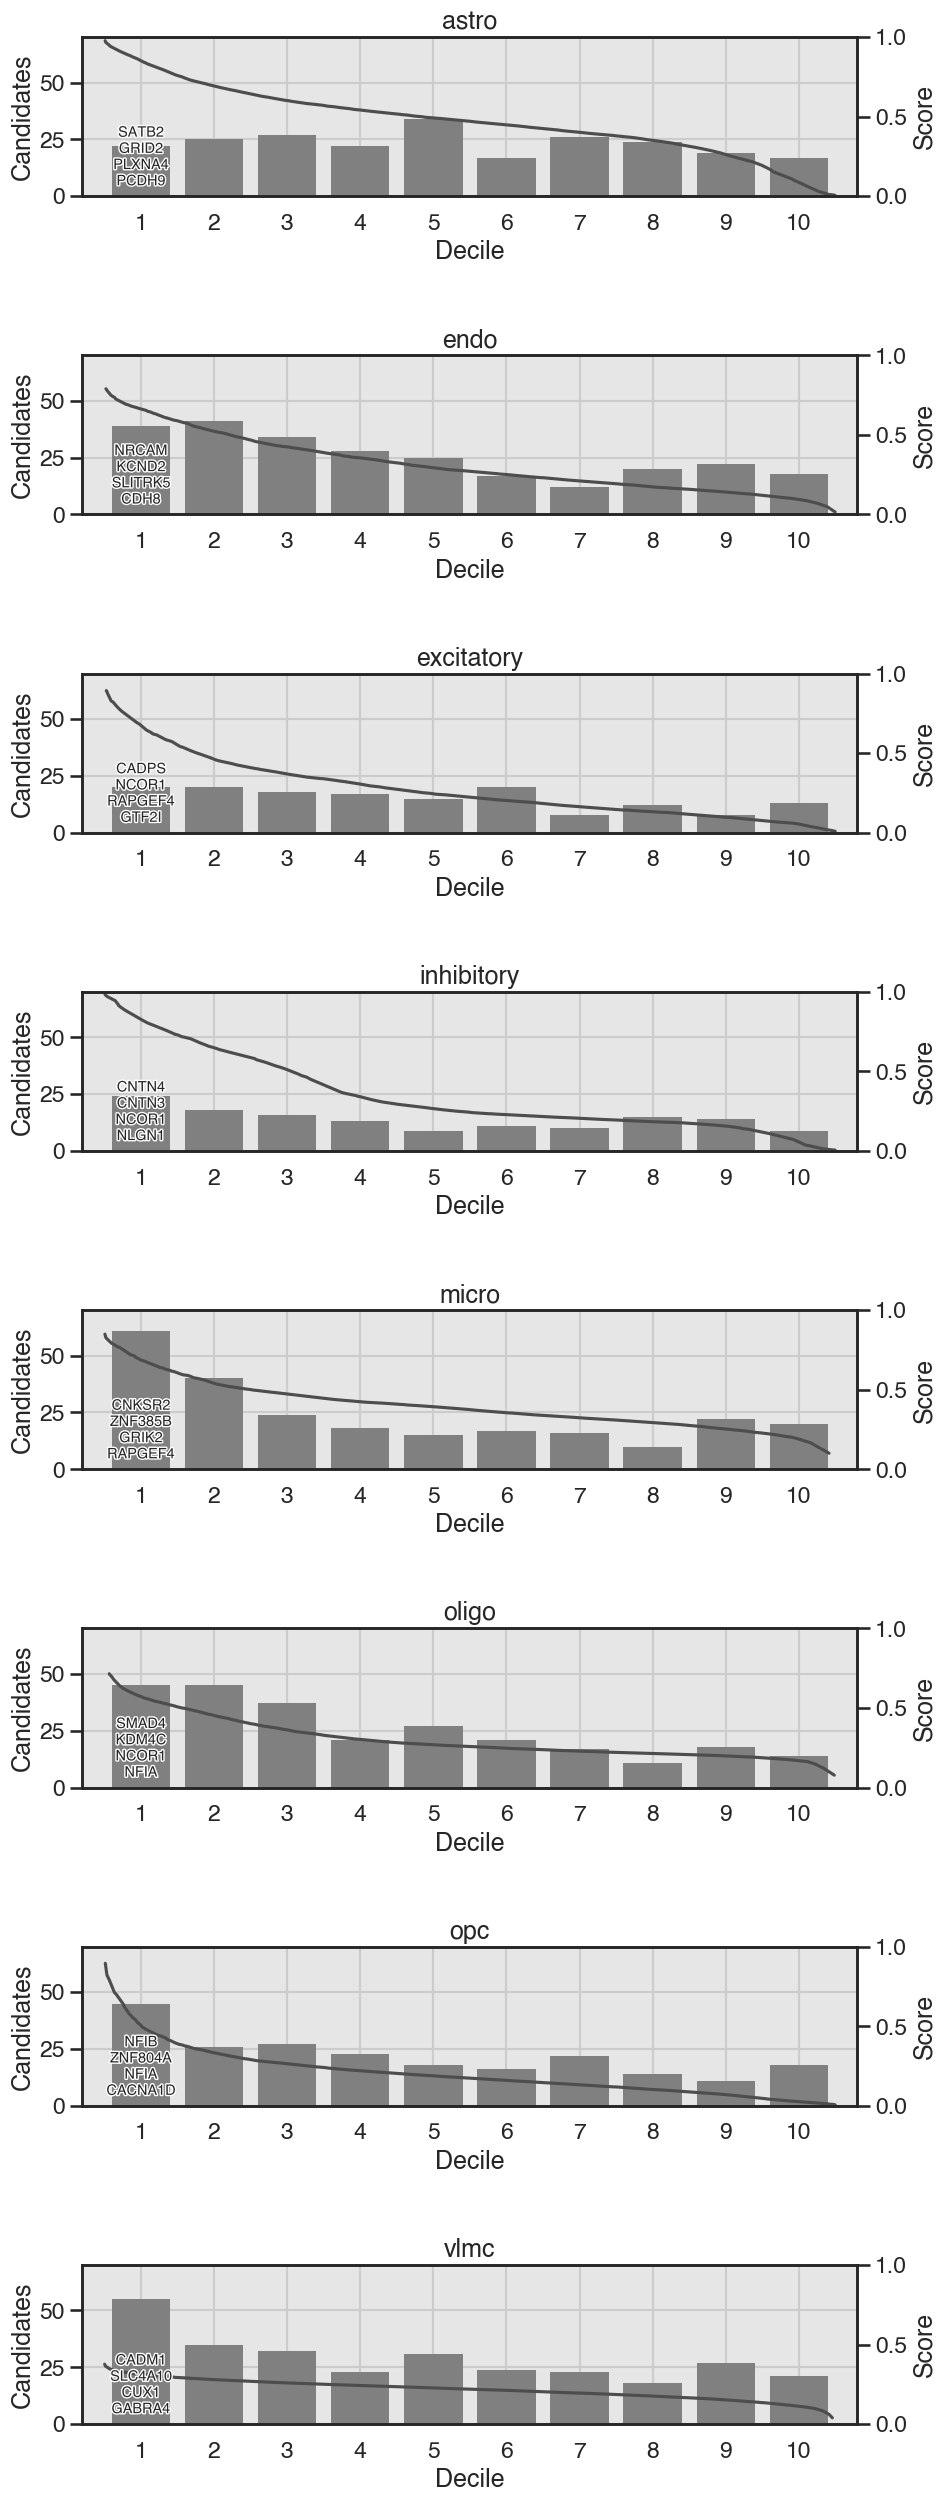

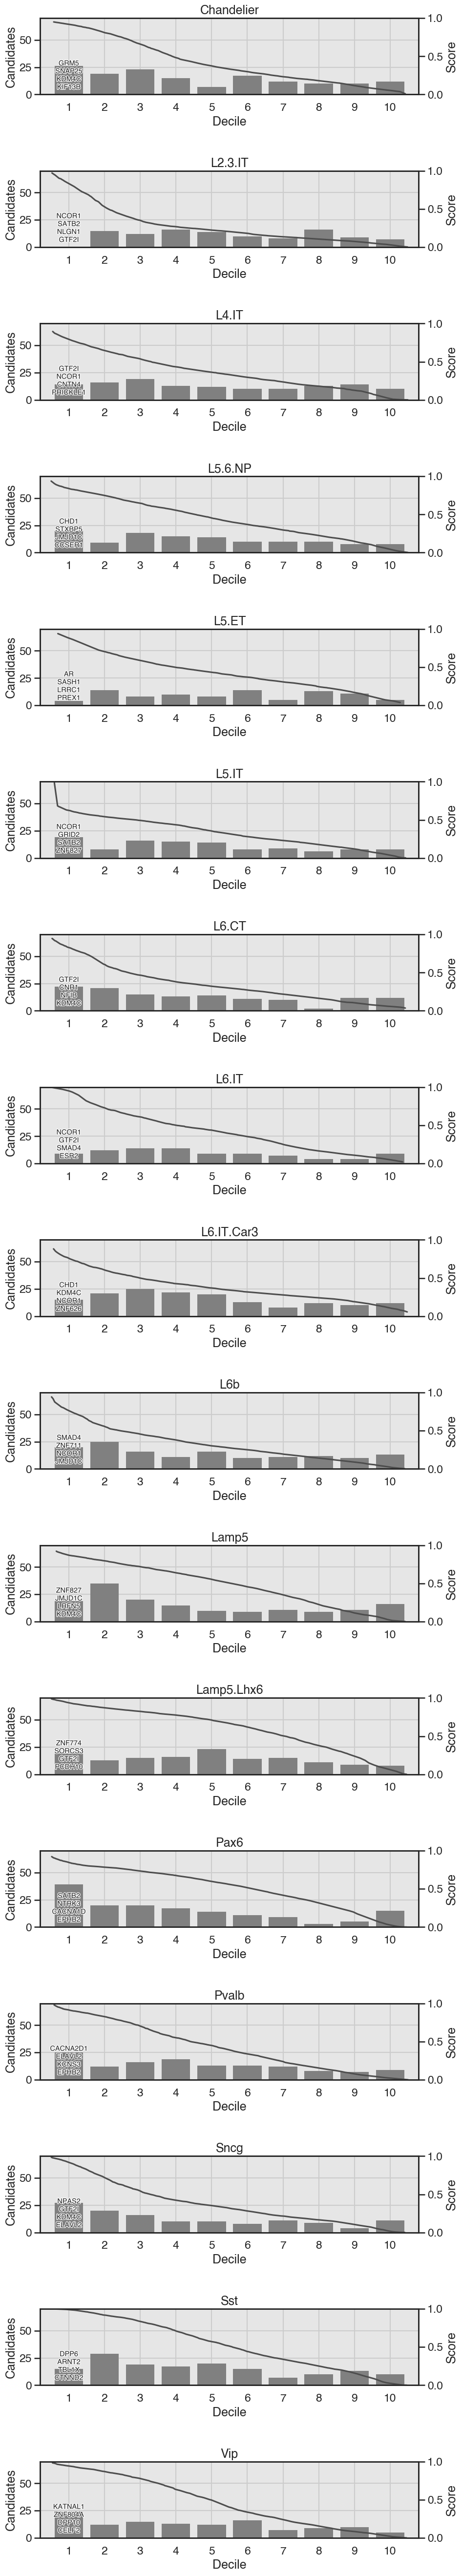

In [15]:
for name, idx in zip(('major', 'minor'), ((2, 'UCLA_ASD', 'ASD'), (2, 'Subclass', 'ASD'))):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        df_raw = results_candidates.loc[idx]
        # df_raw.loc[(df_raw['Candidate'])*(df_raw['Label']==1), 'Candidate'] = False  # Filter out positive candidates
        # df_raw.loc[(df_raw['Candidate'])*(df_raw['Label']==0), 'Candidate'] = False  # Filter out negative candidates
        df_raw = df_raw.loc[df_raw['Candidate']]
        df_raw = df_raw.sort_values('Mean')
        df_bar = decile_counts.loc[idx]
    cell_types = df_bar.index.unique().sort_values()
    fig, axs = plt.subplots(len(cell_types), 1, figsize=(10, 4*len(cell_types)-1), sharex=True, sharey=True)
    fig.subplots_adjust(hspace=1)
    axs[0].set_xlim([.2, 10.8])
    axs[0].set_ylim([0, 70])
    for ct, ax in zip(cell_types, axs):
        # Set color
        color = merged_colors[ct]
        # Plot
        ax.bar(range(1, 11)[::-1], df_bar.loc[df_bar.index == ct, 'Candidates'], fc=color, ec=(0, 0, 0, 0))
        # Estimate KDE
        # kernel = scipy.stats.gaussian_kde(df_raw.loc[df_raw.index == ct, 'Percentile'].to_numpy())
        # x = np.linspace(0, 1, num=101)
        # ax.plot(10*x+.5, 1_000*kernel(x))
        # Opposite axis
        axo = ax.twinx()
        axo.plot(.5 + (100 - df_raw.loc[df_raw.index == ct, 'Percentile']) / 10, df_raw.loc[df_raw.index == ct, 'Mean'], color=(.3, .3, .3, 1))
        axo.set_ylim([0, 1])
        axo.set_ylabel('Score')
        # Labels
        ax.set_xlabel('Decile')
        ax.set_ylabel('Candidates')
        ax.set_title(ct)
        # Ticks
        ax.set_xticks(range(1, 11))
        ax.xaxis.set_tick_params(labelbottom=True)
        # Formatting
        ax.set_facecolor((.9, .9, .9, 1))
        ax.grid('minor')
        # Add top 4 candidate genes
        top_genes = df_raw.loc[df_raw.index == ct].sort_values('Mean', ascending=False).iloc[:4]['Gene'].to_list()
        trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
        import matplotlib.patheffects as pe
        axo.text(
            1, .05, '\n'.join(top_genes),
            ha='center', va='bottom', fontsize='xx-small',
            path_effects=[pe.withStroke(linewidth=2, foreground="white")],
            transform=trans)

    # Save
    fname = f'decile_{name}.pdf'
    fig.savefig(os.path.join(PLOTS_FOLDER, fname), bbox_inches='tight')

### Specific Genes

In [12]:
novel_genes = None
for ct in merged_ct:
    # Filter to desired genes
    filtered_results = results.loc[(results['Cell Type'] == ct) * (results['Model'] == 2)]
    if filtered_results.shape[0] == 0: break  # Skip cts with no results
    scores_by_disease = filtered_results.groupby(['Disease', 'Gene']).mean(numeric_only=True).reset_index()
    # Calculate percentiles for each disease
    diseases = scores_by_disease['Disease'].unique()
    for disease in diseases:
        disease_subset = scores_by_disease.loc[scores_by_disease['Disease'] == disease]
        scores_by_disease.loc[scores_by_disease['Disease'] == disease, 'Percentile'] = disease_subset.apply(lambda r: 100 * (r['Mean'] > disease_subset['Mean']).sum() / (disease_subset.shape[0]), axis=1)
    # Only keep top desired percentile
    scores_by_disease = scores_by_disease.loc[scores_by_disease['Percentile'] > 90]
    # Filter only to genes tested in all diseases
    gene_counts = scores_by_disease.groupby('Gene').count()[['Disease']].rename(columns={'Disease': 'Count'}).reset_index()
    genes = gene_counts.loc[gene_counts['Count'] == diseases.shape[0], 'Gene'].to_list()
    scores_by_disease = scores_by_disease.loc[scores_by_disease['Gene'].isin(genes)]
    # Filter only to genes unknown or negative in at least one disease
    gene_labels = scores_by_disease.groupby('Gene').min()[['Label']].reset_index()
    genes = gene_labels.loc[gene_labels['Label'] < 1, 'Gene'].to_list()
    scores_by_disease = scores_by_disease.loc[scores_by_disease['Gene'].isin(genes)]
    # Produce output
    new_genes = pd.DataFrame({'Gene': scores_by_disease['Gene'].unique(), 'Cell Type': ct})
    novel_genes = pd.concat((novel_genes, new_genes), axis=0)
    # CLI
    print(f'Found {new_genes["Gene"].unique().shape[0]} novel genes for {ct}')
# CLI
print(f'Found {novel_genes["Gene"].unique().shape[0]} novel genes total')

Found 2 novel genes for astro
Found 12 novel genes for endo
Found 25 novel genes for excitatory
Found 14 novel genes for inhibitory
Found 51 novel genes for micro
Found 65 novel genes for oligo
Found 79 novel genes for opc
Found 2 novel genes for vlmc
Found 7 novel genes for Lamp5
Found 0 novel genes for Pvalb
Found 7 novel genes for Sncg
Found 4 novel genes for Sst
Found 0 novel genes for Lamp5.Lhx6
Found 5 novel genes for Vip
Found 0 novel genes for Pax6
Found 4 novel genes for Chandelier
Found 11 novel genes for L2.3.IT
Found 5 novel genes for L4.IT
Found 8 novel genes for L5.IT
Found 1 novel genes for L5.ET
Found 1 novel genes for L5.6.NP
Found 4 novel genes for L6b
Found 0 novel genes for L6.IT
Found 3 novel genes for L6.CT
Found 2 novel genes for L6.IT.Car3
Found 249 novel genes total


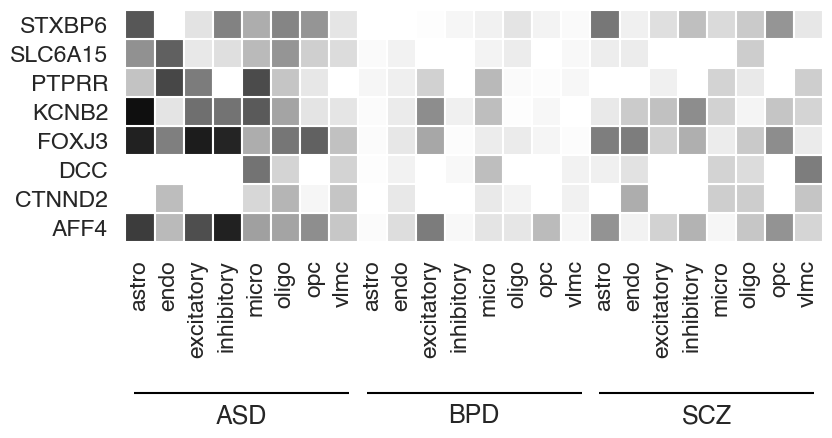

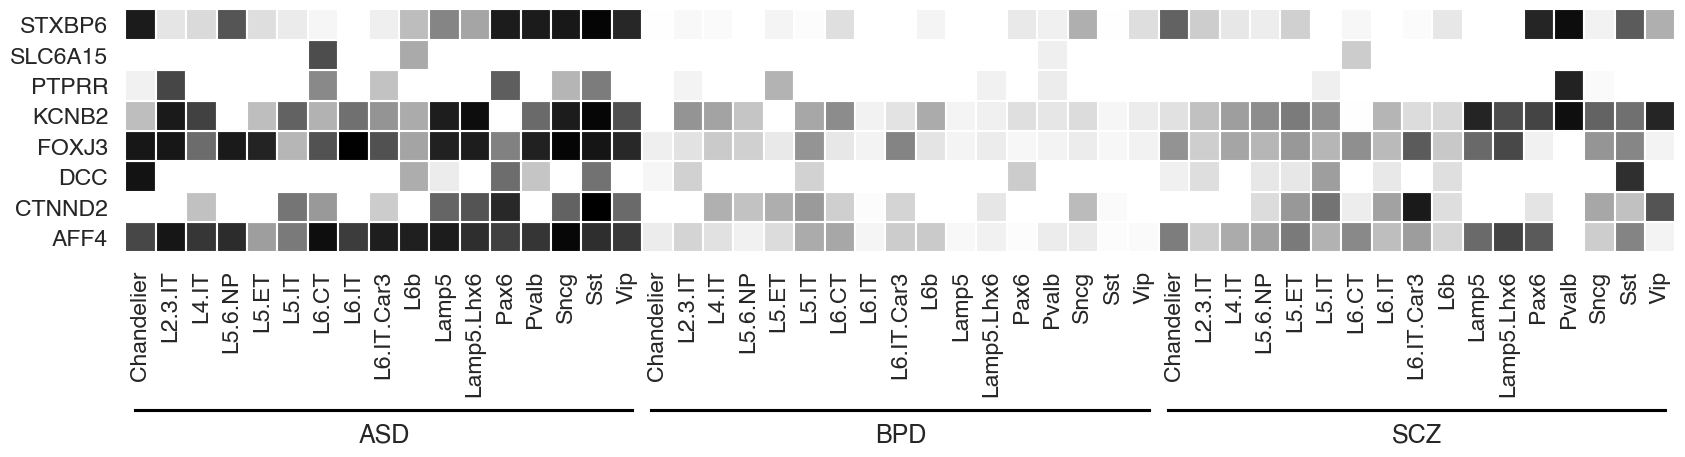

In [13]:
for name, ct_to_use in zip(('major', 'minor'), (major_ct, minor_ct)):
    # # Get top genes from each disease, not using missing values in mean calculations
    # num_top_genes = 3
    # min_gene_count = 20
    # top_genes = results.groupby(['Gene', 'Disease']).mean(numeric_only=True)[['Mean']]
    # # Only take genes with counts over 10
    # genes_over_threshold = results.groupby(['Gene']).count()['Mean'] > min_gene_count
    # genes_over_threshold = genes_over_threshold.index[genes_over_threshold].to_list()
    # top_genes = top_genes.loc[top_genes.index.get_level_values('Gene').isin(genes_over_threshold)]
    # # Filter to top genes
    # top_genes = top_genes.reset_index('Gene').sort_values('Mean').groupby(['Disease']).head(num_top_genes)['Gene'].unique()  # Extract top genes

    # Previous novel gene computation
    # np.random.seed(42)
    # top_genes = np.random.choice(novel_genes['Gene'], 9, replace=False)

    # Manually set gene computation (randomly selected)
    top_genes = np.array(['AFF4', 'SLC6A15', 'DCC', 'KCNB2', 'PTPRR', 'KCNB2', 'FOXJ3', 'STXBP6', 'CTNND2'])

    # Get values for top genes and select cts
    df = results.loc[results['Gene'].isin(top_genes)]
    df = df.loc[df['Cell Type'].isin(ct_to_use)]
    df = df.loc[df['Model'] == 2]

    # Format df
    df['Name'] = df.apply(lambda r: f'{r["Disease"]} - {r["Cell Type"]}', axis=1)
    heatmap_1 = df.pivot(index='Gene', columns='Name', values='Mean')

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(int(.4*heatmap_1.shape[1]), 10))

    # Define vars
    xlabels = heatmap_1.columns.to_list()
    ylabels = heatmap_1.index.to_list()
    m, n = heatmap_1.shape[1], heatmap_1.shape[0]
    X, Y = np.meshgrid(np.arange(m), np.arange(n))
    S = heatmap_1.to_numpy()

    # Model 1 is dashed
    cmap = matplotlib.colormaps['Greys']
    patches = [plt.Rectangle((j-.5, i-.5), 1, 1) for j, i in zip(X.flat, Y.flat)]
    col = PatchCollection(patches, array=S.flatten(), cmap=cmap, clim=[0, 1])
    ax.add_collection(col)

    # Modify colors to match cell types
    # fig.canvas.draw()
    # facecolors = col.get_facecolors()
    # for i, x, y in zip(range(facecolors.shape[0]), X.flat, Y.flat):
    #     disease, ct = xlabels[x].split(' - ')
    #     facecolors[i] = merged_colors[ct]
    # col.set_array(None)
    # col.set_facecolors(facecolors)
    # fig.canvas.draw()

    # Revise xlabels
    xdiseases = [l.split(' - ')[0] for l in xlabels]
    xlabels = [l.split(' - ')[1] for l in xlabels]

    # Draw group labels
    trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
    ypos = -.65; ypos_text = -.15
    lidx = 0
    for ridx in range(len(xdiseases)):
        if (ridx == len(xdiseases) - 1) or (xdiseases[ridx+1] != xdiseases[ridx]):
            # Draw label
            xpos = (lidx + ridx) / 2
            label = f'{xdiseases[ridx]}'
            # TODO: Maybe separate subclass and non-subclass?
            # if groups[ridx] == 'Subclass': label += ' Subclass'
            ax.text(xpos, ypos + ypos_text, label, ha='center', va='bottom', fontsize='medium', transform=trans)

            # Draw lines
            ax.arrow(
                lidx-.2, ypos, ridx - lidx + .4, 0,
                width=.002,
                head_width=0,
                transform=trans,
                color='black',
                clip_on=False)

            # Iterate
            lidx = ridx + 1

    # Set ticks
    ax.set(
        xticks=np.arange(m),
        yticks=np.arange(n),
        xticklabels=xlabels,
        yticklabels=ylabels,
    )
    ax.set_xticks(np.arange(m+1)-.5, minor=True)
    ax.set_yticks(np.arange(n+1)-.5, minor=True)
    ax.tick_params(axis='x', labelrotation=90)
    # ax.grid(which='minor')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim([-.5, heatmap_1.shape[1]-.5])
    ax.set_ylim([-.5, heatmap_1.shape[0]-.5])

    # Formatting
    ax.spines.left.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.bottom.set_visible(False)

    # Save
    fname = f'novel_{name}.pdf'
    fig.savefig(os.path.join(PLOTS_FOLDER, fname), bbox_inches='tight')

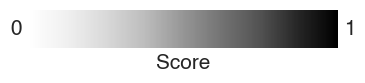

In [14]:
# Save colorbar legend
fig, ax = plt.subplots(1, 1, figsize=(4, .5))
cbar = fig.colorbar(col, orientation='horizontal', cax=ax)
cbar.ax.set_xlabel('Score', fontsize='small')
# cbar.ax.set_ylabel('a')
# cbar.ax.xaxis.set_label_position('top')
cbar.outline.set_visible(False)
cbar.ax.set_xticks([])
cbar.ax.text(-.02, .5, '0', fontsize='small', ha='right', va='center', transform=cbar.ax.transAxes)
cbar.ax.text(1.02, .5, '1', fontsize='small', ha='left', va='center', transform=cbar.ax.transAxes)
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fname = f'legend_novel.pdf'
fig.savefig(os.path.join(PLOTS_FOLDER, fname), bbox_inches='tight')